## Preamble
Import required libraries and set plotting preferences

In [1]:
import numpy as np, scipy.stats as ss, pandas as pd, statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import pandas.io.data as web
import seaborn as sns #import new pretty plot library
import datetime  

%matplotlib inline
#set plot palette and styles 
sns.set_palette('muted')
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style('dark')

##Download data from Yahoo! Finance

In [2]:
#download all stock data
start = datetime.datetime(2005, 9, 1)
end = datetime.datetime(2010, 9, 3)

stocks = ['VBLTX','FMAGX','SBUX']

all_prices = web.DataReader(stocks, 'yahoo', start, end)

# take only adjusted close price, downsample to monthly, take last price
all_prices=all_prices.ix['Adj Close'].resample('BM','last')
all_prices= all_prices[['VBLTX','FMAGX','SBUX']]

Calculate the continuously compounded returns on all of the data by taking the log differences between data points.

In [3]:
all_returns = np.log(all_prices).diff()
all_returns.head()

,VBLTX,FMAGX,SBUX
Date,,,
2005-09-30,NaN,NaN,NaN
2005-10-31,-0.019540,-0.012929,0.121281
2005-11-30,0.007663,0.032941,0.073931
2005-12-30,0.022205,0.019588,-0.014555
2006-01-31,-0.009222,0.046623,0.054786


As always, it's good to visualize what we're working with, so let's plot the distributions of the continuously compounded returns.

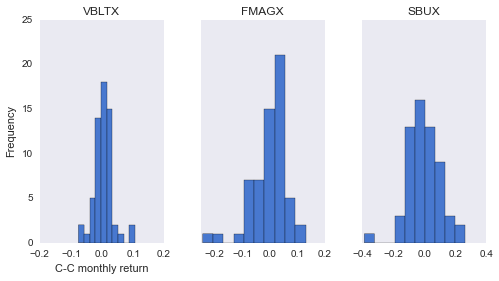

In [4]:
f, axs = plt.subplots(1,3,sharey =True)
plt.subplots_adjust(hspace= 0.1,wspace=0.3)
f.set_figheight(4)
f.set_figwidth(8)

axs[0].hist(all_returns.VBLTX[1:])
axs[0].set_xlabel('C-C monthly return')
axs[0].set_ylabel('Frequency')
axs[0].set_title('VBLTX')
plt.sca(axs[0])
plt.xticks(np.linspace(-0.2,0.2,5))


axs[1].hist(all_returns.FMAGX[1:])
axs[1].set_title('FMAGX')
plt.sca(axs[1])
plt.xticks(np.linspace(-0.2,0.2,5))

axs[2].hist(all_returns.SBUX[1:])
plt.sca(axs[2])
axs[2].set_title('SBUX')
_=plt.xticks(np.linspace(-0.4,0.4,5))


#Constant Expected Return Model:

Consider

\begin{equation}
R_{it} = \mu_{i} + \epsilon_{it}
\end{equation}

\begin{equation}
t = 1...T
\end{equation}

\begin{equation}
\epsilon_{it} = \text{iid } N(0,\sigma_{i}^2)
\end{equation}

\begin{equation}
cov(\epsilon_{it},\epsilon_{jt}) = \sigma_{ij}
\end{equation}

Where $R_{it}$ is the continuously compounded return on asset $i$ (VBLTX, SBUX, or FMAGX) at time $t$. This model assumes Normally distributed returns, covariance stationarity in their time series. From our data, let's estimate $\sigma_{i}^2$ (sample variance) for the diferent assets, and the precision in our estimates by calculating the standard error (SE) where

\begin{equation}
\hat{\text{SE}}(\hat{\sigma_{i}^2}) = \hat{\sigma_{i}^2} / \sqrt{(T/2)}
\end{equation}

In [5]:
n_obs = all_returns.shape[0] #number of observations

sigma2hat_vals = all_returns.var() #sample variance

sigma2hat = sigma2hat_vals/np.sqrt(n_obs/2)

##Estimate the standard error of the correlation parameter:

Let's compute the correlations between each return time series, $\rho_{ij}$, and their standard error. The standard error is calculated using 

\begin{equation}
\hat{\text{SE}}(\hat{\rho_{it}}) = (1-\hat{\rho_{it}}^2) / \sqrt{T}
\end{equation}

In [6]:
cor_matrix=all_returns.corr()
cor_matrix

,VBLTX,FMAGX,SBUX
VBLTX,1.000000,0.185986,-0.141939
FMAGX,0.185986,1.000000,0.608742
SBUX,-0.141939,0.608742,1.000000


Let's grab the correlation values that aren't on the diagonal.

In [7]:
rhohat_vals = cor_matrix.values[np.triu_indices_from(cor_matrix.values,1)] #grab the upper triangular

se_rhohat = (1-rhohat_vals**2)/np.sqrt(n_obs)  #compute the  standard errors of rhohat

pd.DataFrame({'rhohat': rhohat_vals ,'se_rhohat':se_rhohat},index=['VBLTX-FMAGX','VBLTX-SBUX','FMAGX-SBUX'])


,rhohat,se_rhohat
VBLTX-FMAGX,0.185986,0.123608
VBLTX-SBUX,-0.141939,0.125457
FMAGX-SBUX,0.608742,0.080591


We can better visualize this using a corrplot matrix as shown below:

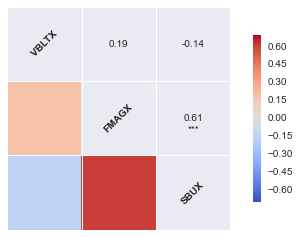

In [8]:
_=sns.corrplot(all_returns[1:])

##Hypothesis Testing for Asset Return Means:
Let's compute a 1-sample on our VBLTX return distribution. This is to test if VBLTX returns come from a distribution with mean = 0. 

\begin{eqnarray}
H_0&:& \mu_i = 0 \\
H_1 &:& \mu_i \neq0
\end{eqnarray}

In [9]:
t,p_val=ss.ttest_1samp(all_returns.VBLTX[1:],0)
p_val

0.15095045492524209

P>0.05, so we cannot reject the null hypothesis that this distribution does not have mean = 0. In fact, mean of VBLTX returns is

In [10]:
all_returns.VBLTX.mean()

0.0055773452459030167

Let's apply this test to all our returns (i.e. each column). A nifty way to accomplish this is to create a lambda function and use .apply() to apply to each column of our dataframe.

In [11]:
all_returns[1:].apply(lambda x: ss.ttest_1samp(x,0))

VBLTX      (1.45506847176, 0.150950454925)
FMAGX     (-0.187131394933, 0.85219964327)
SBUX     (0.0127171221506, 0.989896383414)
dtype: object

This returns tuples of (t-statistic, p-value) for each column. All these P values are greater than 0.05, so we cannot reject the hypothesis that their means that do not equal 0.

##Hypothesis Testing for Asset Return Correlations:
For each correlation, we want to test


\begin{eqnarray}
H_0&:& \rho_{ij} = 0 \\
H_1 &:& \rho_{ij} \neq0
\end{eqnarray}

again using 5% significance level. We can do this by calling the pearsonr() function from scipy.stats.


In [12]:
rho, p_val =ss.pearsonr(all_returns.VBLTX[1:],all_returns.FMAGX[1:]) #correlation between VBLTX and FMAGX
p_val

0.15479998614935597

Since the P value is greater than 0.05, we cannot reject $H_0$. Similarly for the correlation between VBLTX and SBUX.

In [13]:
rho, p_val =ss.pearsonr(all_returns.VBLTX[1:],all_returns.SBUX[1:]) #correlation between VBLTX and FMAGX
p_val

0.27933454145926562

##Testing for Normality:
\begin{eqnarray}
H_0 &:& r_{it}  \text{ ~ Normal} \\
H_1 &:& r_{it}  \text{ ~ Not Normal}
\end{eqnarray}

Ideally, I'd like to use the Jarque-Bera test, but can't seem to find it implemented in Python, so I'm going to use scipy.stats.mstats.normaltest, which according to the documents is based on the D'Agnostino and Pearson's omnibus test for normality.

In [14]:
k2,p_val=ss.mstats.normaltest(all_returns.VBLTX[1:]) #k2 is the z-scored kurtosis test value returned
p_val

0.0052180041987529716

P<0.05 in this case, therefore, at the 5% significance level, we do reject the Null hypothesis $H_0$ that the distribution is Normal. We can now do this for all the returns, as before.

In [15]:
all_returns[1:].apply(lambda x: ss.mstats.normaltest(x))

VBLTX     (10.5112805752, 0.00521800419875)
FMAGX    (19.5321432812, 5.73652613617e-05)
SBUX       (8.66769357022, 0.0131169920648)
dtype: object

This yields a tuple (k2,p_val) for each asset return time series. In each case, we can reject the Null hypothesis at the 5% significance level.

##Bootstrapping:
Let's now bootstrap the sample mean. Define a function to take as input the data, the number of samples we'd like to sample from the data, with replacement, and the function we'd like to pass. In this case, we're going to pass the np.mean function.

In [16]:
def bootstrap(data, num_samples, statistic):
    n= len(data)
    samples= np.random.choice(data,(num_samples,n))
    stat = np.sort(statistic(samples,axis=1))
    return stat

Generate 999 means using our bootstrap function above.

In [17]:
boot_means=bootstrap(all_returns.VBLTX[1:],999,np.mean)

Now let's plot the distribution of the bootstrapped means, and the quantile-quantile plot, to see how to compares to the normal distribution.

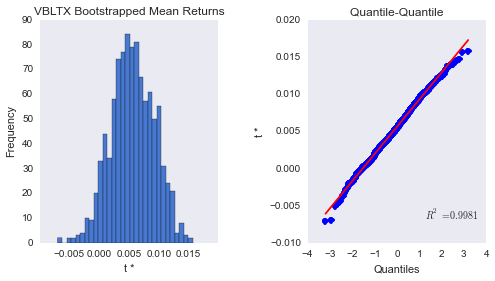

In [18]:
f, axs = plt.subplots(1,2)
plt.subplots_adjust(hspace= 0.1,wspace=0.5)
f.set_figheight(4)
f.set_figwidth(8)

axs[0].hist(boot_means,30)
plt.sca(axs[0])
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('t *')
axs[0].set_title('VBLTX Bootstrapped Mean Returns')
_=plt.xticks(np.linspace(-0.005,0.015,5))

res=ss.probplot(boot_means, dist="norm",plot=axs[1])
axs[1].set_ylabel('t *')
axs[1].set_title('Quantile-Quantile ')